In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
#import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from datetime import datetime
from google.colab import files
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS # for MDS dimensionality reduction

from sklearn.mixture import GaussianMixture
from sklearn import metrics

In [3]:
#upload normalised dataset
norm_df=pd.read_csv('/content/normalised_data.csv',sep = '\,', header = 0, engine = 'python')

In [5]:
norm_df.drop(['Unnamed: 0'],axis=1,inplace=True )

In [6]:
#Find the highly correlated features.
#need to confirm weather these highly correlated features drop from data set
correlated_features = set() #use set data structure for avoid duplicates
correlation_matrix = norm_df.corr()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(correlated_features)

{'Deviation_of_accelerometer_6mwt_split2_v3', 'Maximum_of_accelerometer_6mwt_split3_v2', 'Minimum_of_accelerometer_6mwt_split3_v1', 'Minimum_of_accelerometer_6mwt_split4_v3', 'Deviation_of_accelerometer_6mwt_split4_v2', 'Minimum_of_accelerometer_sct_split2_v3', 'panas_neg_t4', 'Deviation_of_accelerometer_6mwt_split3_v2', 'Deviation_of_accelerometer_6mwt_split2_v1', 'Maximum_of_accelerometer_6mwt_split2_v2', 'Deviation_of_accelerometer_6mwt_split1_v3', 'Maximum_of_accelerometer_6mwt_split4_v1', 'Deviation_of_smartphone_sct', 'Deviation_of_accelerometer_6mwt_split4_v3', 'Minimum_of_accelerometer_6mwt_split4_v2', 'amount_of_confidence_two_in_sct', 'hee_t4', 'Minimum_of_accelerometer_6mwt_split3_v3', 'Deviation_of_accelerometer_6mwt_split2_v2', 'Deviation_of_accelerometer_6mwt_split3_v1', 'Minimum_of_accelerometer_6mwt_split3_v2', 'Minimum_of_fitbit_6mwt.1', 'Deviation_of_accelerometer_6mwt_split4_v1', 'Deviation_of_accelerometer_6mwt_split3_v3', 'Deviation_of_smartphone_6mwt', 'Maximum_of

In [7]:
#drop highly correlated data
norm_df.drop(['panas_neg_t4', 'Minimum_of_accelerometer_6mwt_split3_v1', 'Deviation_of_accelerometer_6mwt_split2_v3', 
               'amount_of_confidence_two_in_sct', 'Minimum_of_fitbit_6mwt.1', 'Minimum_of_accelerometer_6mwt_split4_v2', 
               'Deviation_of_accelerometer_6mwt_split4_v3', 'Minimum_of_accelerometer_sct_split2_v3', 
               'Minimum_of_accelerometer_6mwt_split2_v3', 'Maximum_of_accelerometer_6mwt_split2_v2', 
               'Minimum_of_accelerometer_6mwt_split3_v3', 'Deviation_of_smartphone_sct', 'Deviation_of_smartphone_6mwt', 
               'Deviation_of_accelerometer_6mwt_split3_v3', 'Deviation_of_accelerometer_6mwt_split1_v3', 
               'Minimum_of_accelerometer_6mwt_split4_v3', 'Maximum_of_accelerometer_6mwt_split4_v3', 'Minimum_of_accelerometer_6mwt_split3_v2', 
               'Deviation_of_accelerometer_6mwt_split2_v1', 'Deviation_of_accelerometer_6mwt_split4_v2', 'hee_t4', 
               'Deviation_of_accelerometer_6mwt_split3_v1', 'Maximum_of_accelerometer_6mwt_split4_v1', 
               'Deviation_of_accelerometer_6mwt_split2_v2', 'Maximum_of_accelerometer_6mwt_split3_v2', 
               'Deviation_of_accelerometer_6mwt_split4_v1', 
               'Deviation_of_accelerometer_6mwt_split3_v2'],axis=1,inplace=True)

**Dimensionality reduction : ISOMAP**

In [8]:
#Isomap: non-linear dimensionality reduction
from sklearn import manifold

df_isomap_cpy = norm_df.copy()
iso = manifold.Isomap(n_neighbors=5, n_components=2)
iso.fit(df_isomap_cpy)
manifold_2Da = iso.transform(df_isomap_cpy)
mani_df = pd.DataFrame(manifold_2Da, columns=['c1', 'c2'])


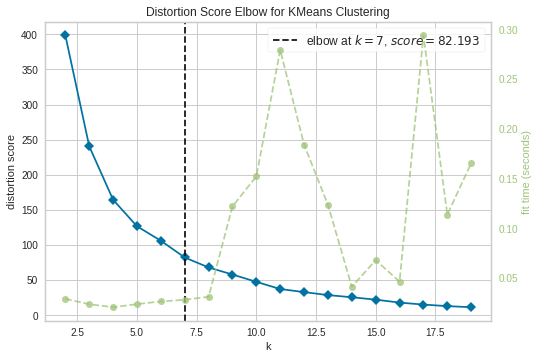

In [10]:
#find optimal value for K for kmeans clustering
kmeans_model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans_model, k=(2,20), timings= True)
visualizer.fit(mani_df)        # Fit data to visualizer
visualizer.show() 

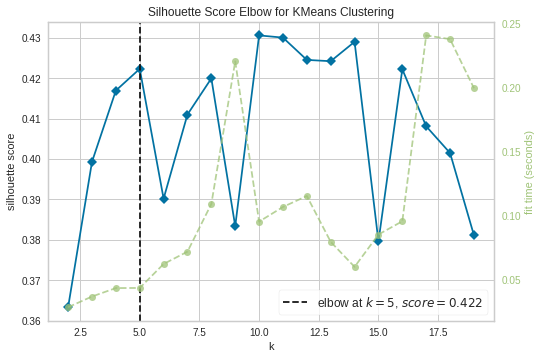

In [11]:
# Silhouette Score for K means
# Import ElbowVisualizer
#from yellowbrick.cluster import KElbowVisualizer
mod1 = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(mod1, k=(2,20),metric='silhouette', timings= True)
visualizer.fit(mani_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

3

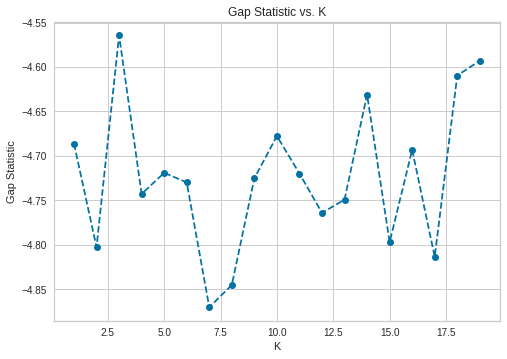

In [12]:
def optimalK(data, nrefs=3, maxClusters=20):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
# Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
# Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
# Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)
score_g, df = optimalK(mani_df, nrefs=3, maxClusters=20)

plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');
score_g

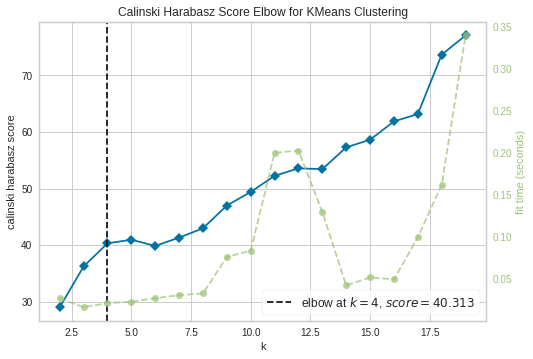

In [13]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
#from yellowbrick.cluster import KElbowVisualizer
mod2 = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(mod2, k=(2,20),metric='calinski_harabasz', timings= True)
visualizer.fit(mani_df)        # Fit the data to the visualizer
visualizer.show()

In [ ]:
#different methods providing different k values. I would like to choose elbow method (k=7 here) because optimal value for kmeans clustering
# is 6 or 7  after various dimensionality reduction implementations on dataset. This conclusion may be incorrect!

In [15]:
#k=7
#Apply Kmeans clustering algorithm
kmeans = KMeans(7)
#Apply kMeans on data
kmeans.fit(mani_df)
labels = kmeans.labels_ #label/ cluster associating to each data points
#this is centroid of all clusters
kmeans.cluster_centers_.shape
#create a data frame having kmeans centroid and col of df1
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [mani_df.columns])
#cluster_centers
y_kmeans = kmeans.fit_predict(mani_df)
#y_kmeans

In [16]:
# concatenate the clusters labels to our original dataframe(norm_df)
df_cluster = pd.concat([norm_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster.head()

,ageGroup,gender,smoker,employed,sports,timeOfDay,testSuit,firstTask,arrival_car/motorcycle,arrival_on foot,arrival_public transport,bmi,dist_6mwt,dist_sct,swe_b_t1,swe_b_t4,swe_m_t1,swe_m_t4,swe_f_t1,swe_f_t4,swe_a_t1,swe_a_t4,hee_t1,facts_t1,facts_t4,bsa_F,bsa_S,abi_p_vig,abi_p_kov,wkv_a_t1,wkv_a_t2,wkv_a_t3,wkv_a_t4,wkv_b_t1,wkv_b_t2,wkv_b_t3,wkv_b_t4,wkv_g_t1,wkv_g_t2,wkv_g_t3,...,amount_of_confidence_one_in_sct,amount_of_confidence_three_in_sct,Maximum_of_accelerometer_6mwt_split1_v1,Minimum_of_accelerometer_6mwt_split1_v1,Deviation_of_accelerometer_6mwt_split1_v1,Maximum_of_accelerometer_6mwt_split2_v1,Minimum_of_accelerometer_6mwt_split2_v1,Maximum_of_accelerometer_6mwt_split3_v1,Minimum_of_accelerometer_6mwt_split4_v1,Maximum_of_accelerometer_6mwt_split1_v2,Minimum_of_accelerometer_6mwt_split1_v2,Deviation_of_accelerometer_6mwt_split1_v2,Minimum_of_accelerometer_6mwt_split2_v2,Maximum_of_accelerometer_6mwt_split4_v2,Maximum_of_accelerometer_6mwt_split1_v3,Minimum_of_accelerometer_6mwt_split1_v3,Maximum_of_accelerometer_6mwt_split2_v3,Maximum_of_accelerometer_6mwt_split3_v3,Maximum_of_accelerometer_sct_split1_v1,Minimum_of_accelerometer_sct_split1_v1,Deviation_of_accerometer_sct_split1_V1,Maximum_of_accelerometer_sct_split2_v1,Minimum_of_accelerometer_sct_split2_v1,Deviation_of_accerometer_sct_split2_V1,Maximum_of_accelerometer_sct_split1_v2,Minimum_of_accelerometer_sct_split1_v2,Deviation_of_accerometer_sct_split1_V2,Maximum_of_accelerometer_sct_split2_v2,Minimum_of_accelerometer_sct_split2_v2,Deviation_of_accerometer_sct_split2_V2,Maximum_of_accelerometer_sct_split1_v3,Minimum_of_accelerometer_sct_split1_v3,Deviation_of_accerometer_sct_split1_V3,Maximum_of_accelerometer_sct_split2_v3,Deviation_of_accerometer_sct_split2_V3,6mwtask1,6mwtask2,sctask1,sctask2,cluster
0,1,0,0,1,1,1,0,1,0,0,1,0.711864,0.083156,0.329114,0.632653,0.843137,0.642857,0.692308,0.578947,0.428571,1.0,1.0,0.882353,0.120301,0.093023,0.247202,0.149632,0.499187,0.640244,1.00,1.00,1.000000,1.000000,1.000000,0.894737,0.727273,0.80,1.0000,1.000000,0.923077,...,0.814815,0.0,0.282158,0.834426,0.303219,0.292077,0.875458,0.330590,0.973480,0.293893,0.794492,0.348033,0.822938,0.284615,0.089716,0.771475,0.049630,0.071970,0.296619,0.806524,0.219814,0.294521,0.917892,0.200622,0.201970,0.864865,0.258731,0.164935,0.853360,0.400822,0.214886,0.913079,0.138895,0.144737,0.125912,0.947368,0.928571,0.818182,0.684211,0
1,0,1,0,1,0,0,1,0,0,1,0,0.627119,0.464819,0.544304,0.020408,0.607843,0.285714,0.846154,0.526316,0.000000,1.0,1.0,0.176471,1.000000,0.434109,0.247202,0.149632,0.400000,0.875000,0.50,0.90,1.000000,0.952381,0.217391,0.631579,0.409091,0.60,0.5000,0.846154,0.846154,...,0.705882,0.0,0.301126,0.755738,0.540913,0.276023,0.822955,0.379287,0.915265,0.413486,0.762712,0.630884,0.752515,0.498901,0.108315,0.736359,0.080741,0.142677,0.341876,0.761530,0.408726,0.407798,0.724265,0.440096,0.223645,0.833333,0.322165,0.457143,0.818737,0.565755,0.109244,0.778229,0.254278,0.137218,0.335416,0.526316,1.000000,0.772727,1.000000,5
2,0,0,0,1,1,0,1,1,1,0,0,0.338983,0.654584,0.506329,0.836735,0.921569,0.928571,0.846154,1.000000,1.000000,1.0,1.0,0.529412,0.097744,0.038760,0.030943,0.128527,0.666667,0.562500,0.45,0.80,0.434783,0.380952,0.478261,0.578947,0.454545,0.50,0.8750,0.769231,0.769231,...,0.603774,0.0,0.426200,0.624590,0.721621,0.433454,0.638584,0.532236,0.826003,0.480916,0.442797,0.690789,0.645875,0.570330,0.239606,0.632091,0.126667,0.236111,0.382225,0.915636,0.290925,0.241834,0.832108,0.287930,0.262069,0.782282,0.301596,0.427273,0.617108,0.533305,0.170468,0.809098,0.212939,0.084586,0.364674,0.947368,1.000000,0.818182,1.000000,2
3,1,1,0,1,1,0,1,0,0,0,0,0.338983,0.581130,0.873418,0.959184,0.823529,1.000000,0.769231,1.000000,0.785714,1.0,0.8,1.000000,0.338346,0.317829,1.000000,0.536050,0.066667,0.625000,0.30,0.55,0.478261,0.095238,0.173913,0.631579,0.590909,0.55,0.0625,0.153846,0.076923,...,0.513514,0.0,0.407825,0.722951,0.544163,0.401864,0.847375,0.486283,0.937904,0.395674,0.449153

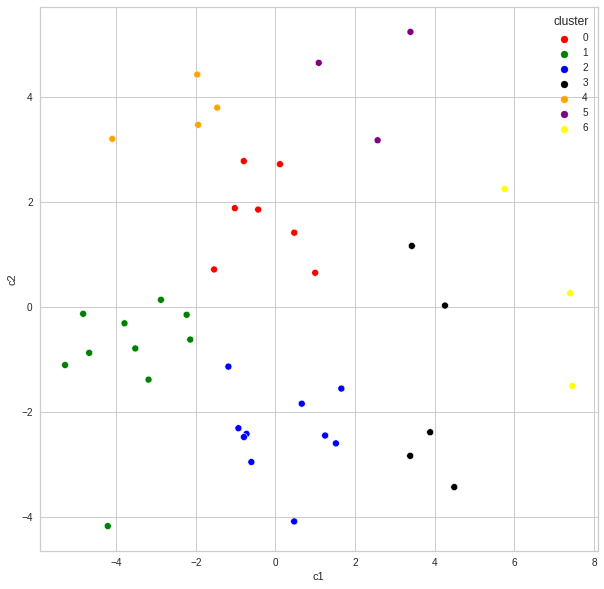

In [19]:
# Concatenate the clusters labels to the dataframe(pca_df)
df_mani_kmeans=pd.concat([mani_df,pd.DataFrame({'cluster':labels})], axis = 1)
#visualize the clusters using principal components
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="c1", y="c2", hue = "cluster", data = df_mani_kmeans, palette =['red','green','blue','black','orange','purple','yellow'])
plt.show()

**Apply HAC Algorithm**

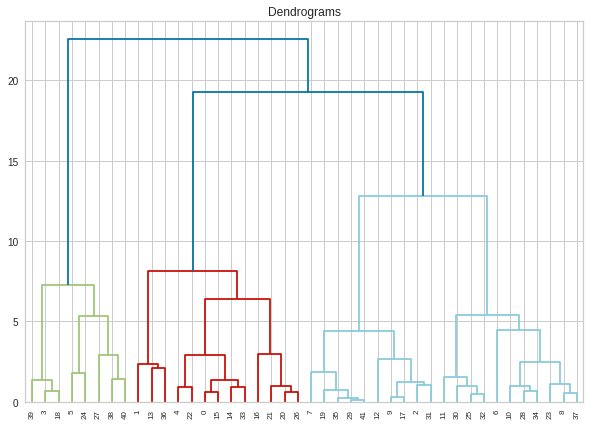

In [21]:
#implement heirarchical clustering.
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(mani_df, method='ward'))

In [22]:
#based on colour , we can decide optimal number of cluster. Or draw a horizontal line over blue line find count of intercet points
optimal_num_clusters=len(set(dend['color_list']))-1
print(optimal_num_clusters)

3


In [26]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
y_hc=cluster.fit_predict(mani_df)
#0 represents the points that belong to the first cluster and 1 represents points in the second cluster and 2 indicates third cluster

In [27]:
# Concatenate the clusters labels to the dataframe(pca_df)
df_mani_cpy=mani_df.copy()
df_mani_hac = pd.concat([df_mani_cpy,pd.DataFrame({'cluster_hac':y_hc})], axis = 1)

In [28]:
df_mani_hac.head()

,c1,c2,cluster_hac
0,-1.020128,1.874784,2
1,3.390147,5.230330,2
2,0.660948,-1.848800,0
3,3.885151,-2.392279,1
4,0.472563,1.407616,2


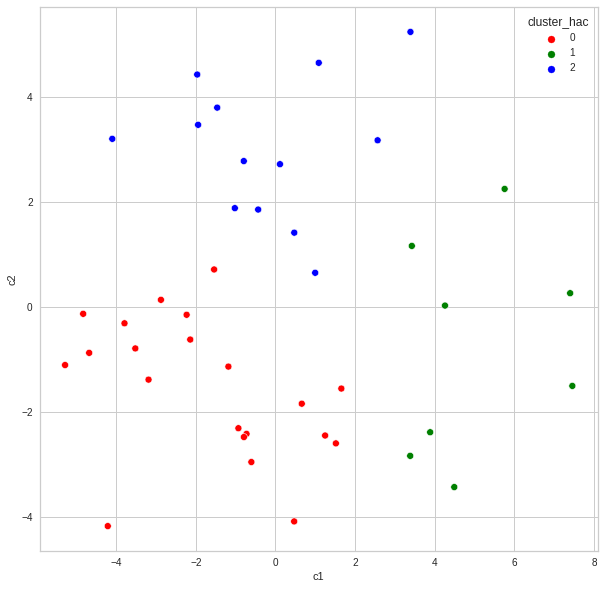

In [31]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="c1", y="c2", hue = "cluster_hac", data = df_mani_hac, palette =['red','green','blue'])
plt.show()

**Apply DBSCAN Algorithm**

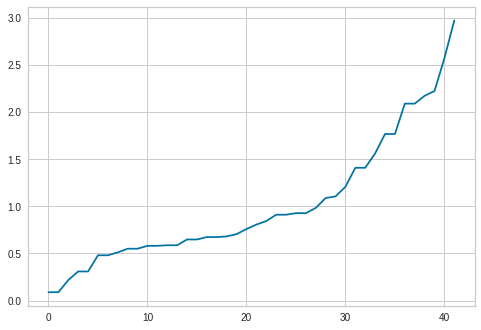

In [35]:
#DBSCAN, let's find appropriate epsilon:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_mani_cpy)
distances, indices = nbrs.kneighbors(df_mani_cpy)
#print(distances)
distances = np.sort(distances, axis=0)
#print('.........................')
#print(distances)
distances = distances[:,1]
plt.plot(distances)

Text(0.5, 1.0, 'DBSCAN on ISOMAP')

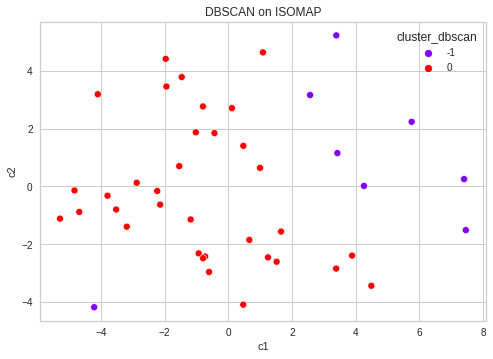

In [38]:
db = DBSCAN(eps=2.3, min_samples=5).fit(df_mani_cpy)
y_dbscan=db.labels_
df_mani_dbscan = pd.concat([df_mani_cpy,pd.DataFrame({'cluster_dbscan':y_dbscan})], axis = 1)
a = sns.scatterplot(x='c1', y='c2', hue = 'cluster_dbscan', data = df_mani_dbscan, palette = 'rainbow')
a.set_title('DBSCAN on ISOMAP')

**Apply Gaussian misture clustering**

In [39]:
#Gaussian misture, let's choose the proper number of clusters:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
for i in range(2, 11):
    gmm = GaussianMixture(n_components=i).fit(df_mani_cpy)
    df_mani_cpy['Cluster'] = gmm.predict(df_mani_cpy)
    d = metrics.silhouette_score(df_mani_cpy, df_mani_cpy['Cluster'], metric='euclidean')
    print(i, d)

2 0.38211851252083956
3 0.29803698074384194
4 0.2118751298894648
5 0.39034713397898263
6 0.3577225902327496
7 0.3918311542152455
8 0.48643602580854134
9 0.4696919774211433
10 0.5398632850194582


In [40]:
df_mani_cpy.head()

,c1,c2,Cluster
0,-1.020128,1.874784,4
1,3.390147,5.230330,3
2,0.660948,-1.848800,6
3,3.885151,-2.392279,2
4,0.472563,1.407616,4


Text(0.5, 1.0, 'Gaussian mixture on ISOMAP')

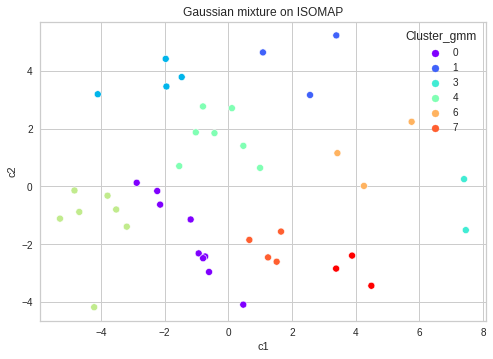

In [41]:
df_mani_cpy.drop(['Cluster'], axis = 1,inplace=True)
gmm = GaussianMixture(n_components=9)
gmm.fit(df_mani_cpy)
df_mani_cpy['Cluster_gmm'] = gmm.predict(df_mani_cpy)
ax = sns.scatterplot(x='c1', y='c2', hue = 'Cluster_gmm', data = df_mani_cpy, palette = 'rainbow')
ax.set_title('Gaussian mixture on ISOMAP')